In [43]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection and Cleaning

In [13]:
df=pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [14]:
df.shape

(72134, 4)

In [15]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [16]:
# Remove rows where 'text' is missing (since it's essential)
df = df.dropna(subset=['text'])

# Replace missing titles with an empty string
df['title'] = df['title'].fillna('')


In [17]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [19]:
df = df.drop(columns=['Unnamed: 0'])


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   72095 non-null  object
 1   text    72095 non-null  object
 2   label   72095 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [23]:
def clean_text(text):
    # Remove HTML tags, URLs, non-alphabet characters
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-letters
    return text.strip()

df['content'] = df['title'] + ' ' + df['text']
df['content'] = df['content'].apply(clean_text)


# Minimal preprocessing & prepare data for LSTM

In [28]:
# Minimal cleaning function (remove non-letters, extra spaces)
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# Combine title and text
df['content'] = (df['title'] + ' ' + df['text']).apply(clean_text)

# Features and labels
X = df['content'].values
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [29]:
df.head()

,title,text,label,content
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,law enforcement on high alert following threat...
1,,Did they post their votes for Hillary already?,1,did they post their votes for hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,unbelievable obamas attorney general says most...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,bobby jindal raised hindu uses story of christ...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,satan russia unvelis an image of its terrifyin...


## Tokenize and pad sequences

In [31]:
max_words = 10000  # vocab size
max_len = 200      # max length of each sequence

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


## Build LSTM model

In [36]:
embedding_dim = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,)),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [37]:
history = model.fit(
    X_train_pad, y_train,
    epochs=8,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/8


I0000 00:00:1747583464.698375     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


812/812 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.6871 - loss: 0.5848 - val_accuracy: 0.7450 - val_loss: 0.5205
Epoch 2/8
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7459 - loss: 0.5378 - val_accuracy: 0.8011 - val_loss: 0.4494
Epoch 3/8
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8333 - loss: 0.4012 - val_accuracy: 0.9137 - val_loss: 0.2657
Epoch 4/8
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9215 - loss: 0.2377 - val_accuracy: 0.9542 - val_loss: 0.1271
Epoch 5/8
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9678 - loss: 0.1035 - val_accuracy: 0.9553 - val_loss: 0.1413
Epoch 6/8
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9750 - loss: 0.0831 - val_accuracy: 0.9638 - val_loss: 0.1059
Epoch 7/8
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9863 - loss: 0.0492 - val_accuracy: 0.9638 - val_loss: 0.1107
Epoch 8/8
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9898 - loss: 0.0376 - val_accuracy: 0.96

## Evaluation on Test Set

In [38]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9686 - loss: 0.1059
Test Accuracy: 0.9672


In [39]:
print(f'Loss: {loss:.4f}')

Loss: 0.1093


451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


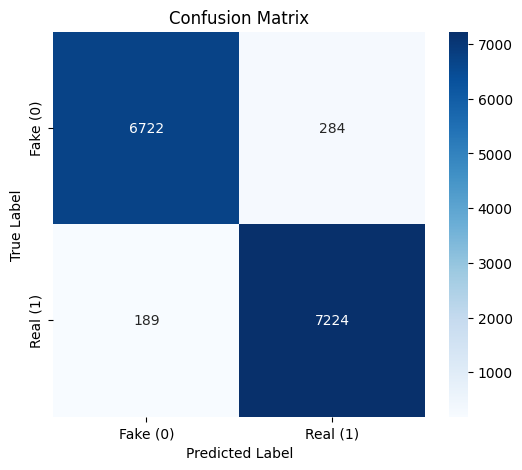

              precision    recall  f1-score   support

        Fake       0.97      0.96      0.97      7006
        Real       0.96      0.97      0.97      7413

    accuracy                           0.97     14419
   macro avg       0.97      0.97      0.97     14419
weighted avg       0.97      0.97      0.97     14419



In [42]:
# Predict probabilities
y_pred_prob = model.predict(X_test_pad)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


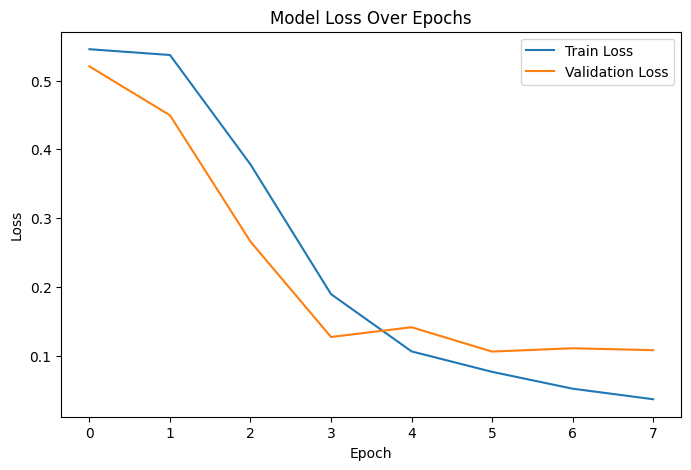

In [44]:
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


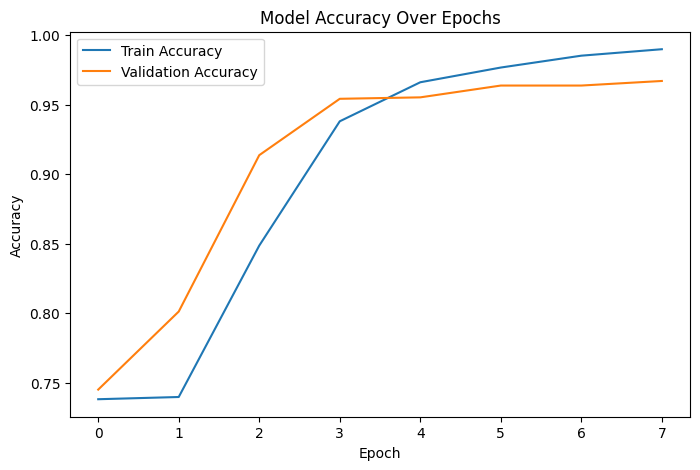

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [46]:
model.save('fake_news_lstm_model.h5')

In [ ]:
import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
